# Modèles statistiques multivariés

La transformée de Fourier nous permet de déceler des saisonnalités cachées dans nos données, et est bien utile pour choisir la saisonnalité d'un modèle SARIMA. 

Cependant, de nombreux phénomènes ont plusieurs saisonnalités et des patterns plus complexes.

Pour reprendre l'exemple de la consommation électrique en Allemagne : 

- saisonnalité journalière (heures pleines vs heures creuses)
- saisonnalité hebdomadaire (weekends vs jours ouvrés)
- saisonnalité annuelle (été vs hiver)
- ...

D'autre part, ces variations peuvent s'expliquer par d'autres facteurs : 
- température
- prix de l'électricité 
- ...

Pour capturer ces variations, on utilise des **modèles multivariés**, c'est-à-dire des modèles qui prennent en compte plusieurs variables.

Typiquement, les données d'entrées ressemblent à ça : 

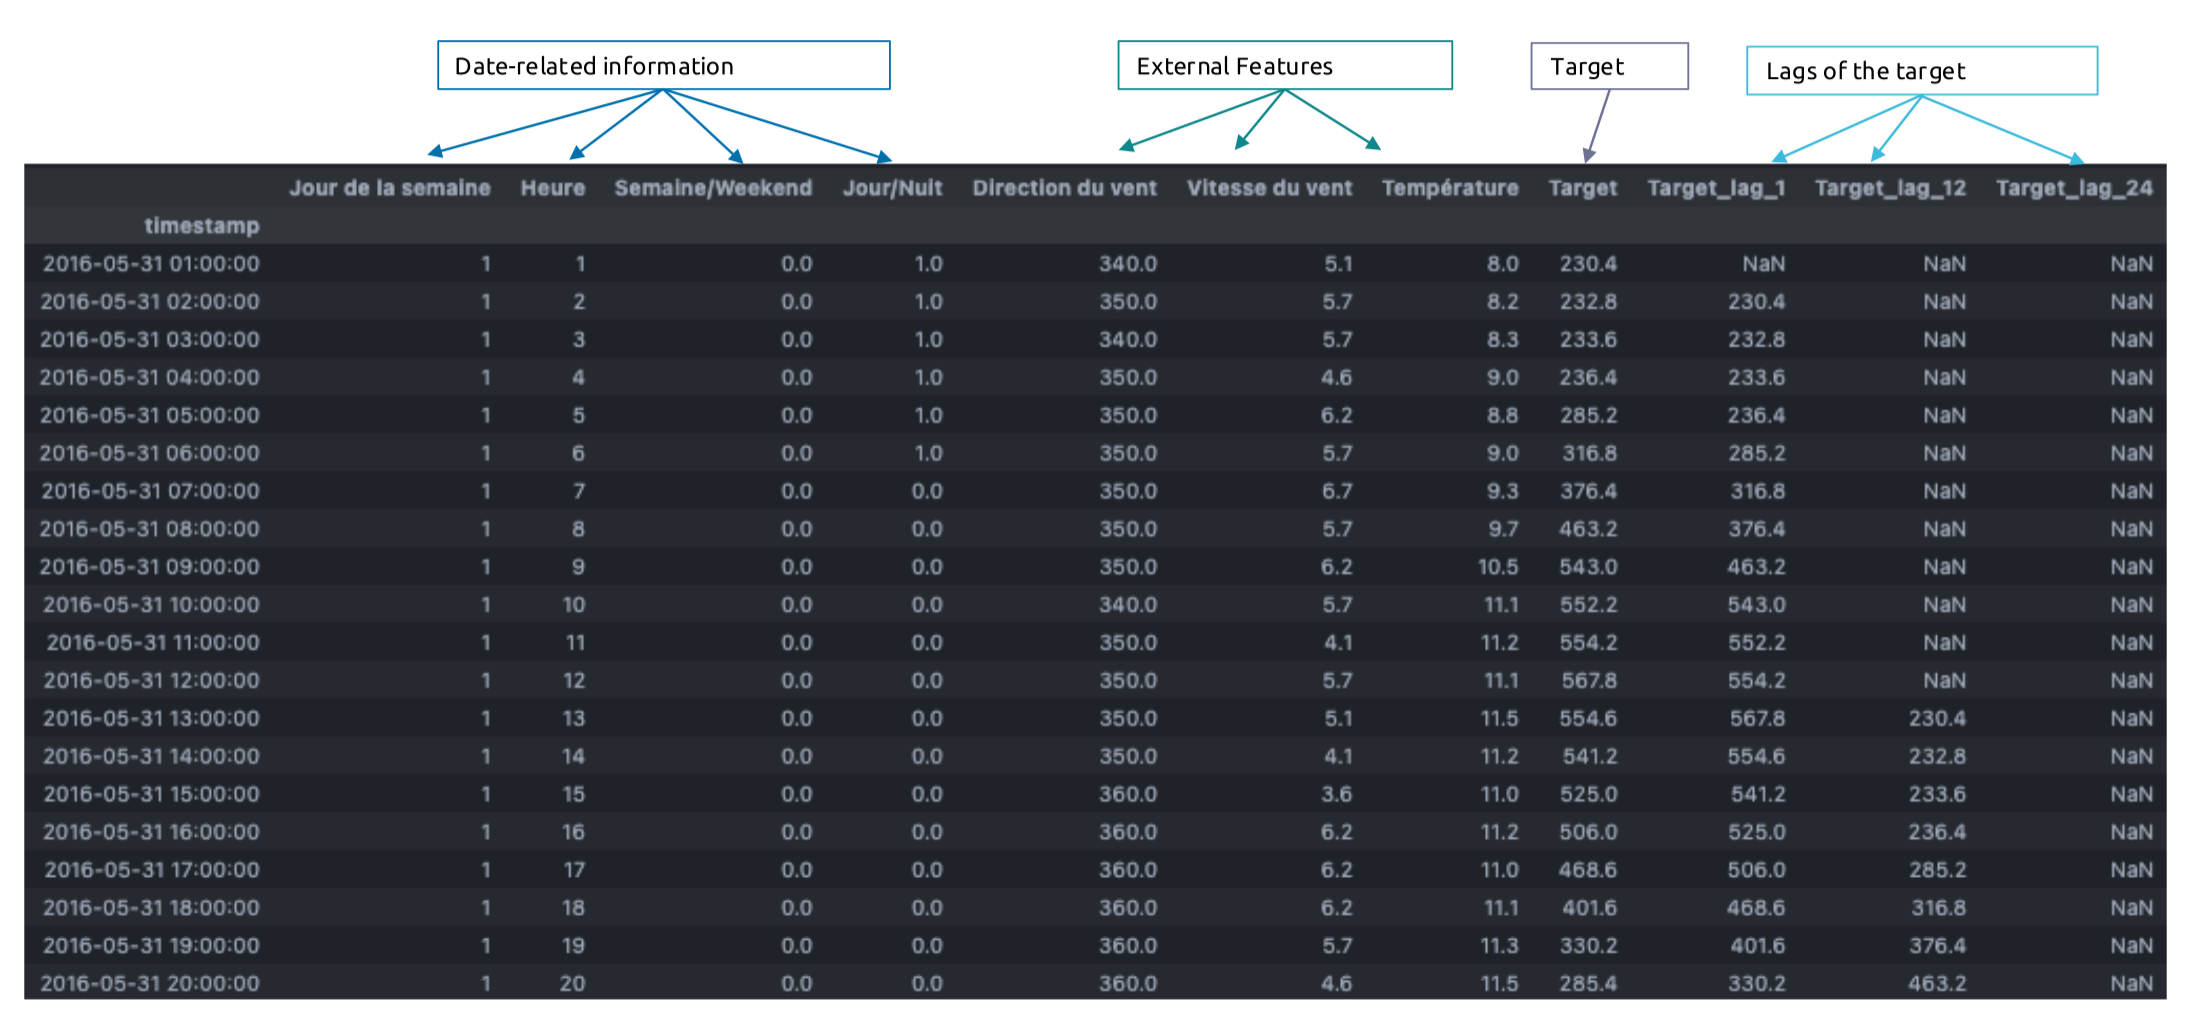

## Modèles multivariés classiques 

Il y a ceux que vous connaissez déjà : 

- Régression Linéaire / Lasso / Ridge / Elasticnet

Les extensions de ceux que vous venez d'apprendre : 

- ARIMA**X** / SARIMA**X** / ARMA**X**

Et ceux que vous verrez bientôt :

- RandomFOrest, XGBoost, Prophet, LTSM ...



## Feature engineering pour les séries temporelles

Classiquement on performe une EDA (plots des moyennes par jour / semaine ..., Transformée de Fourier ...), si l'EDA semble indiquer une relation intéressante, on en fait une feature avec : 

-  `OneHotEncoding` : isweekend / is holidays ...
-  Termes de Fourier
-  Encodage cyclique , voir [docsklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html) 
-  autres encodings (polynomial, interaction ...)

## Modélisation

On peut ensuite suivre le cycle classique de modélisation : 

- choix d'un ou plusieurs modèle 
- grid search des hyperparamètres du modèle, des transformations
- validation du modèle 
- prédiction

## Exercice pratique : bike demand dataset


Nous allons nous exercer à partir d'un dataset réel : 


Extrait de la documentation : *The core data set is related to
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA*

[source initiale](https://www.openml.org/search?type=data&sort=runs&id=42712&status=active) 

### 1. Chargement des données et EDA

In [64]:
import pandas as pd
import statsmodels.api as sm

# Charger le dataset
data = sm.datasets.get_rdataset("AirPassengers").data
data['Month'] = pd.to_datetime(data['time'], format='%Y-%m')
data.set_index('Month', inplace=True)
ts = data['value']

print(ts.head())


ValueError: time data "1949" doesn't match format "%Y-%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [65]:
data

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
...,...,...
139,1960.583333,606
140,1960.666667,508
141,1960.750000,461
142,1960.833333,390


In [52]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./bike_sharing_prepared.csv")
df.head()

,holiday,weather,temp,feel_temp,humidity,windspeed,count,date
0,False,clear,9.84,14.395,0.81,0.0,16,2011-01-06 00:00:00
1,False,clear,9.02,13.635,0.80,0.0,40,2011-01-06 01:00:00
2,False,clear,9.02,13.635,0.80,0.0,32,2011-01-06 02:00:00
3,False,clear,9.84,14.395,0.75,0.0,13,2011-01-06 03:00:00
4,False,clear,9.84,14.395,0.75,0.0,1,2011-01-06 04:00:00


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   holiday    17379 non-null  bool   
 1   weather    17379 non-null  object 
 2   temp       17379 non-null  float64
 3   feel_temp  17379 non-null  float64
 4   humidity   17379 non-null  float64
 5   windspeed  17379 non-null  float64
 6   count      17379 non-null  int64  
 7   date       14877 non-null  object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 967.5+ KB


In [67]:
df = pd.read_csv("data_beijing.csv")
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


Affichez les valeurs manquantes

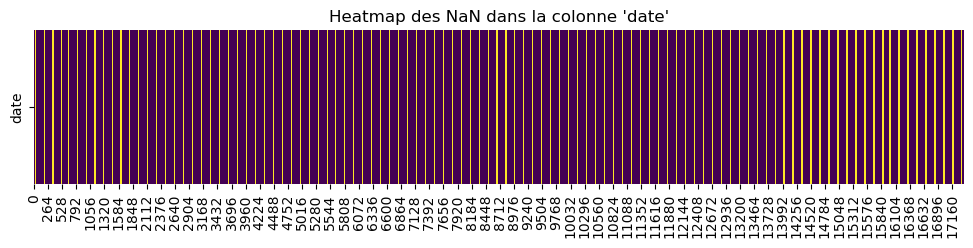

In [53]:
na_array = pd.DataFrame(df["date"].isna().values, columns=["date"])

plt.figure(figsize=(12,2))
sns.heatmap(na_array.T, cbar=False, cmap="viridis")
plt.title("Heatmap des NaN dans la colonne 'date'")
plt.show()

In [59]:
len(pd.DatetimeIndex(pd.date_range(start=date_min, end=date_max, freq='h')))

16704

In [60]:
date_min, date_max = df["date"][0], df["date"].iloc[-1]
idx = pd.DatetimeIndex(pd.date_range(start=date_min, end=date_max, freq='h'))
df.set_index(idx)

ValueError: Length mismatch: Expected 17379 rows, received array of length 16704

In [63]:
date_range = pd.date_range(start=date_min, end=date_max, freq='h')
df.reindex(date_range).isna().sum()

holiday      16704
weather      16704
temp         16704
feel_temp    16704
humidity     16704
windspeed    16704
count        16704
date         16704
dtype: int64

Convertissez la colonne date en type `datetime` et mettez là en index de la df. 
Spécifiez la fréquence (horaire) de l'index.

In [27]:
df

,holiday,weather,temp,feel_temp,humidity,windspeed,count,date
0,False,clear,9.84,14.395,0.81,0.0000,16,2011-01-06 00:00:00
1,False,clear,9.02,13.635,0.80,0.0000,40,2011-01-06 01:00:00
2,False,clear,9.02,13.635,0.80,0.0000,32,2011-01-06 02:00:00
3,False,clear,9.84,14.395,0.75,0.0000,13,2011-01-06 03:00:00
4,False,clear,9.84,14.395,0.75,0.0000,1,2011-01-06 04:00:00
...,...,...,...,...,...,...,...,...
17374,False,misty,10.66,12.880,0.60,11.0014,119,2012-12-01 19:00:00
17375,False,misty,10.66,12.880,0.60,11.0014,89,2012-12-01 20:00:00
17376,False,clear,10.66,12.880,0.60,11.0014,90,2012-12-01 21:00:00
17377,False,clear,10.66,13.635,0.56,8.9981,61,2012-12-01 22:00:00


In [ ]:
df["date"] = pd.to_datetime("date", format="%Y-%m-%d %H:%M:%S", 
df.set_index("date", inplace=True)

ValueError: time data "date" doesn't match format "%Y-%m-%d %H:%M:%S", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Représentez graphiquement les différentes time series

TypeError: no numeric data to plot

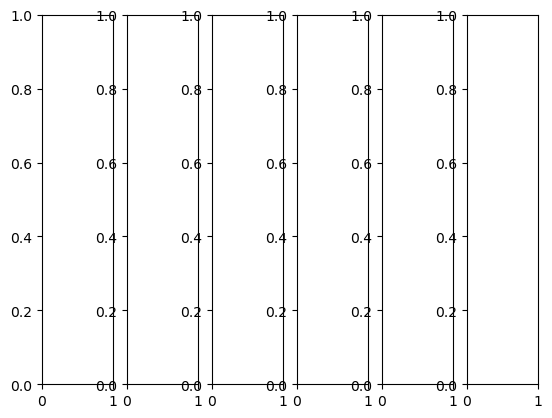

In [ ]:
cols_to_plot =
fig, axs = plt.subplots(1, 6)


for i, col in enumerate(df.columns);


Créez les features suivantes avec pandas: 

- dayofweek
- hour
- month
- season 

[ça peut vous aider de regarder ça](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, RegressorMixin

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None
        self.results_ = None

    def fit(self, X, y=None):
        # SARIMAX attend une série 1D
        self.model_ = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.results_ = self.model_.fit(disp=False)
        return self

    def predict(self, X):
        # X n'est pas utilisé, on prédit sur la longueur de X
        n_steps = len(X)
        forecast = self.results_.get_forecast(steps=n_steps).predicted_mean
        return forecast
